# Data Understanding and Feature Engineering

This Notebook ideally follows the `data_exploration` one.

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Uncomment the next line and install the package, in case you don't have it in your environment
#%pip install procyclingstats

In [3]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import procyclingstats as pcs
import re
import seaborn as sns
import sys
import scipy.stats as stats



sys.path.append('../dataset/')
sys.path.append('../utility/')

from utility.data_understanding import *
from utility.overall_utilities import save_plot

In [4]:
IMAGES_DIR = 'Images'

In the `data_exploration` notebook we've assessed the quality of the data, also adressing some problems that were discovered.

### Dataframes

Motivated by the "imputation by scraping", we decided to retrieve data from (procyclingstats)[https://www.procyclingstats.com/index.php], which is a trusted source of data on cyclism. <br>
The `procyclingstats` notebook details the process of web scraping and data retrieval & augmentation.

In [5]:
cyclist_df = pd.read_csv(os.path.join('dataset','cyclists_new.csv'))
races_df = pd.read_csv(os.path.join('dataset','races_new.csv'))

The dataframes have to be preprocessed in order to be used

In [6]:
cyclist_df = cyclist_df.drop(columns=['Unnamed: 0'], errors='ignore')
cyclist_df['full_history'] = cyclist_df['full_history'].apply(ast.literal_eval)

In [7]:
races_df = races_df.drop(columns=['Unnamed: 0'], errors='ignore')

In [8]:
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality,points_total,tot_seasons_attended,full_history
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy,15.0,2,"[{'season': 1989, 'points': 14.0, 'rank': 828}..."
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France,4717.0,11,"[{'season': 1997, 'points': 164.0, 'rank': 257..."
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands,315.0,10,"[{'season': 2024, 'points': 30.0, 'rank': 990}..."
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium,953.0,9,"[{'season': 2023, 'points': 298.0, 'rank': 218..."
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain,459.0,5,"[{'season': 2024, 'points': 197.0, 'rank': 317..."


In [9]:
races_df.head()

,_url,name,stage_type,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,RR,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,team/flandria-velda-lano-1978,0.0
1,tour-de-france/1978/stage-6,Tour de France,RR,70.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,team/ti-raleigh-mc-gregor-1978,0.0
2,tour-de-france/1978/stage-6,Tour de France,RR,50.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,team/flandria-velda-lano-1978,0.0
3,tour-de-france/1978/stage-6,Tour de France,RR,40.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,team/c-a-1978,0.0
4,tour-de-france/1978/stage-6,Tour de France,RR,32.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,team/miko-mercier-1978,0.0


## Added features

Let's discuss feature augmentation and feature engineering

### Added features (scraping)

We decided to add the following features, obtained by scraping the website:

For the `cyclists` dataset:
- `full_history`: the rider’s points per season history, obtained by reading the *PCS Ranking position per season* table 
- `points_total`: the rider's points accumulated throughout his career, obtained by summing the values in the aforementioned table
- `tot_season_attended`: the number of seasons ran by the cyclist
We decided not to use these features for now, because the data they contain comes from many cyclism disciplines, whereas the data at our disposal only includes road races.

For the `races` dataset:
- `stage_type`: can be RR (Road Race), ITT (Individual Time Trial), TTT (Team Time Trial). Obtained from the stage's webpage

The following changes were made, w.r.t. the original `races` dataset:
- The column `name` now has a unique identifier for each race. Races with identical `_url` prefix are the same race, but in the original dataset they might have been referred with multiple names
- The values in the `points` and `uci_points` column  are now those coming from the website. In the original dataset the (UCI) points were those of the first runner-up 
- The values in the `cyclist_team` column are now those coming from the website. 

In [10]:
cyclist_df = cyclist_df.drop(columns=['points_total', 'tot_seasons_attended','full_history'], errors='ignore')
cyclist_df.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


### Other added features (races)

By comparing the values with the website, we noticed that the `date` column includes the date of the competition and the time the cyclist took to complete the race. So we disentangle such values.

In [11]:
races_df['time'] = races_df['date'].apply(lambda string: string.split(' ')[1])
races_df['date'] = races_df['date'].apply(lambda string: string.split(' ')[0])

#### Steepness

Another feature is the ratio between the vertical meters and the length of the stage, in percentage. This is a "climb density", or steepness.

In [12]:
races_df['steepness'] = 100*races_df['climb_total']/races_df['length']

#### Season

We also add the season in which a race is ran, by looking at the date.

In [13]:
# 0: winter, 1: spring, 2: summer, 3: fall
races_df['season'] = races_df['date'].apply(lambda data: (int(data.split('-')[1])//3)%4)

#### `is_staged`

Some competitions are composed of multiple stages, each of which is ran in a different day. One example of this is the Giro d'Italia. Some other are ran in a single stage (that takes a single day), one example being the Ronde van Vlaanedren.

In [14]:
races_df['is_staged'] = races_df['_url'].apply(lambda race_url: bool(re.match(r"[a-z0-9-]+/\d{4}/(prologue|stage-\d)",race_url)))

In [15]:
gare_non_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[~races_df['is_staged'],'_url'].unique()])
gare_tappe = np.unique([gara.split('/')[0] for gara in races_df.loc[races_df['is_staged'],'_url'].unique()])

print(f"Non-staged races: {gare_non_tappe}")
print()
print(f"Staged races: {gare_tappe}")

Non-staged races: ['amstel-gold-race' 'dwars-door-vlaanderen' 'e3-harelbeke' 'gp-montreal'
 'gp-quebec' 'il-lombardia' 'la-fleche-wallone' 'liege-bastogne-liege'
 'milano-sanremo' 'omloop-het-nieuwsblad' 'paris-roubaix'
 'ronde-van-vlaanderen' 'san-sebastian' 'strade-bianche'
 'world-championship']

Staged races: ['dauphine' 'giro-d-italia' 'gran-camino' 'itzulia-basque-country'
 'paris-nice' 'tirreno-adriatico' 'tour-de-france' 'tour-de-romandie'
 'tour-de-suisse' 'uae-tour' 'volta-a-catalunya' 'vuelta-a-espana']


Some competitions take place in the same location each year, while others change location each year.

In [16]:
# Mmm I don't know how to do this... Domain knowledge?

#### Country of the competition

Another trivial yet interesting feature is the country in which the competition is held. It's domain knowledge, summarized in the following dictionary.

**OSS**: This dictionary, and the following cells that create the `race_country` column, use the values of the `name` column in the `races_new.csv` file! 

In [17]:
# For this dictionary I use the names in the races_new.csv format!
country_competition_dict = {
    'France' : ['Tour de France', 
                'Paris - Nice',
                'Criterium du Dauphiné',
                'Paris - Roubaix'],
    'Spain' : ['La Vuelta ciclista a España',
                'Volta Ciclista a Catalunya',
                'Gran Camiño',
                'Itzulia Basque Country',
                'Clasica Ciclista San Sebastian'],
    'Italy' : ['Tirreno-Adriatico', 
               'Milano-Sanremo',
               "Giro d'Italia",
               'Monte Paschi Eroica', 
               'Giro di Lombardia'],
    'Belgium' : ['Ronde van Vlaanderen - Tour des Flandres ME',
                 'La Flèche Wallonne',
                 'E3 BinckBank Classic',
                 'Liège - Bastogne - Liège',
                 'Dwars door België / À travers la Belgique',
                 'Omloop Het Nieuwsblad ME'
                 ],
    'Netherlands' :['Amstel Gold Race'],
    'Switzerland' : ['Tour de Suisse',
                     'Tour de Romandie'],
    'UAE' : ['UAE Tour'],
    'Canada' : ['Grand Prix Cycliste de Quebec', 
                'Grand Prix Cycliste de Montréal']
    # 'World Championships - Road Race' doesn't take place in a fixed country
}

In [18]:
def coutry_returner(race_name:str,
        countries_races_dict:dict[str,list[str]] = country_competition_dict) -> str:
    for country, names_list in countries_races_dict.items():
        if race_name in names_list:
            return country
    return np.nan

races_df['race_country'] = races_df['name'].apply(coutry_returner)

#### Normalized scores

Now, we'll try to infer some value regarding the performance of each individual cyclist at a given age. 
We try to compute an age performance index: it will assign greater values based on the points and the oldness of the cyclist at a given race.

In [19]:
# First, we normalize the scores
races_df['norm_points'] = races_df.groupby('_url')['points'].transform(
    lambda x: (x - x.mean()) / x.std()
)
# Then, we multiply by age
races_df['age_performance_index'] = races_df['norm_points'] * races_df['cyclist_age']

Now, we are going to do the same process for the `startlist_quality`. By engineering this feature, we may infer a set of points to assign to each race that is more nuanced towards the expertise of the cyclists that will participate in it.

In [20]:
races_df['quality_adjusted_points'] = races_df['norm_points'] * races_df['startlist_quality']

Now we'll define a feature to better determine a stamina indicator for each race. We want to take into account any factor that might indicate the need of a better stamina.

In [21]:
races_df['normalized_length'] = races_df['length'] / races_df['length'].max()
races_df['normalized_quality'] = races_df['startlist_quality'] / races_df['startlist_quality'].max()
races_df['normalized_steepness'] = races_df['steepness'] / races_df['steepness'].max()
races_df['profile_adjustment'] = (races_df['profile'] - 1) / 3
# if we manage to impute temperature would be great to have it normalized and used here. Maybe normalization should be over a bimodal? Higher on the extremes?
# races_df['temperature_impact'] = (races_df['average_temperature'] - 20)**2 / 100 # 20 is the ideal temperature, 100 is 10^2, defines how sensitive the model is to deviations

# Apply weights based on factor importance for stamina
races_df['stamina_index'] = (
    races_df['normalized_length'] * 0.25 +
    races_df['normalized_quality'] * 0.25 +
    races_df['normalized_steepness'] * 0.25 +
    races_df['profile_adjustment'] * 0.25
    # + races_df['temperature_impact'] * 0.25
)


### Other added features (cyclists)

#### BMI

We add the BMI (body Mass Index) of each cyclist: the ratio between the weight (kilograms) and the height in square meters.

In [22]:
cyclist_df['bmi'] = cyclist_df['weight']/np.square(cyclist_df['height']/100)

#### Experience level

Now, let's try to infer an experience level for the cyclists. We should take into account everything, but to have a relaxed yet probably closer-to-the-truth model we'll only take into account the races that the cyclists ran into.

In [23]:
race_count = races_df.groupby('cyclist')['_url'].count()

race_count_df = pd.DataFrame({'_url': race_count.index, 'race_count': race_count.values})
cyclist_df = cyclist_df.merge(right=race_count_df, how='left', on='_url')
cyclist_df['race_count'] = cyclist_df['race_count'].replace(np.nan, 0)

# now with all of our complete, total, absolute domain knowledge we can define the experience levels
experience_levels = ['beginner', 'developing', 'competitive', 'semi-pro', 'pro']
bins = [0, 15, 50, 100, 200, float('inf')]

cyclist_df['experience_level'] = pd.cut(cyclist_df['race_count'], bins=bins, labels=experience_levels, right=False)

#### Total score, victories by points

Now we compute the total score collected by each cyclist throughout his career. That is, we just retrieve all the score of a given cyclist and sum it up. Some comments:
- This analysis is made possible by the use of the scraped version of the dataset, because in it the points are relative to the cyclist's position and not to the stage.
- However, there are many NaNs, because very few cyclists, compared to how many participate to a stage, get points
- *Having the most points in a competition doesn't always imply the victory of that competition*. This is expecially true for the Grand Tours, for example, in the Tour de France the points classification is a minor classification
- Of course, for the single-staged races such as the Paris-Roubaix the cyclist with the highest score is also the first one that arrived, and is also the winner.

In [24]:
punti_totali = races_df.groupby('cyclist')['points'].sum()
cyclist_df['total_points'] = cyclist_df['_url'].apply(lambda x: punti_totali[x] if x in punti_totali.index else 0)

We also add a count of how many *competitions* (not how many stages!) were won by points. As said earlier, a victory by points is not the same as a "true" victory, but it seems like that's the most we can do. In fact, to obtain the "true" victory (in staged races) we should either have
- Domain knowledge, or...
- ... more data (as the "true" victory is a combination of factors)

In [25]:
cyclist_df['victories_by_points'] = 0

def get_base_url(url: str) -> str:
    parts = url.split('/')
    return f"{parts[0]}/{parts[1]}"

# Group by the base URL and cyclist, then sum the points
grouped = races_df.groupby([races_df['_url'].apply(get_base_url), 'cyclist'])['points'].sum()

# Find the top scorer for each base URL. 
# We group by URL (1st level of the multi-index), 
# then we find the index (i.e. the cyclist's url) of the max value (i.e. the points)
top_scorers = grouped.groupby(level=0).idxmax().apply(lambda x: x[1])

# Count the victories by points for each cyclist, by just counting how
# many times they appear in top_scorers
victories_by_points = top_scorers.value_counts()

# Update the cyclist_df with the victories by points
cyclist_df['victories_by_points'] = cyclist_df['_url'].map(victories_by_points).fillna(0).astype(int)

The function above is not 100\% reliable, because in case of ties it's not extremely clear how the function awards the victory. Probably alphabetical. 

In fact, an equivalent method with a `for` loop yielded very similar results, with differences just involving a dozen of cyclist for the reason just described. For example, in the 2020 Giro d'Italia it was Arnaud Démare that won by points, but Filippo Ganna had the same amount of points. The method presented here gives the victory to Démare, but the `for` loop gave it to Ganna.

#### Average position

Now we compute the average position of each cyclist throughout his career. 
- Albeit interesting, we don't differentiate between the various competitions
- As with all the average, should be taken with a grain of salt. Is really a cyclist that only participated to a single stage of a minor competition and arrived first that better than a cyclist that attended multiple competitions, sometimes not finishing first? 

These two factors limit the strength of any conclusion that we reach by analizing this feature.

In [26]:
posizioni = races_df.groupby('cyclist')['position']
average_position = posizioni.mean()
cyclist_df['average_position'] = cyclist_df['_url'].apply(lambda x: average_position[x] if x in average_position.index else np.nan)

In [27]:
print(f"The cyclist with the lowest average position is {cyclist_df.loc[cyclist_df['_url'] == average_position.idxmin(), 'name'].iloc[0]},")
print(f"with an average position of {average_position.min()}.")

The cyclist with the lowest average position is Adriano Pella,
with an average position of 0.0.


In [28]:
cyclist_df[cyclist_df['_url'] == average_position.idxmin()][['name','race_count','experience_level','total_points','victories_by_points','average_position']]

,name,race_count,experience_level,total_points,victories_by_points,average_position
2816,Adriano Pella,1.0,beginner,50.0,0,0.0


## Studying the (added?) features

Let's do some data understanding with (also) the new features that we discovered!

### Exploration of `stage_type`

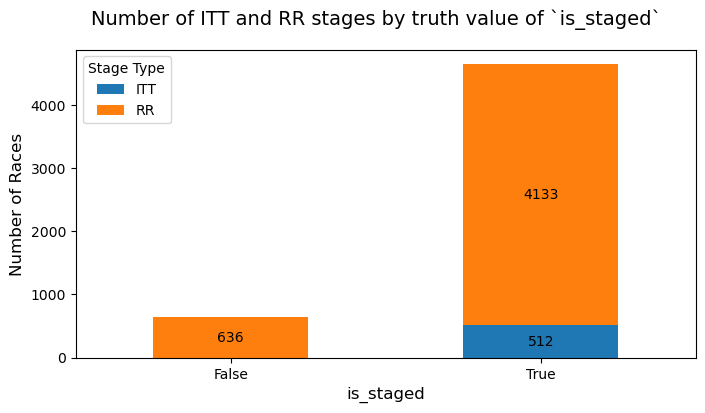

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Number of ITT and RR stages by truth value of `is_staged`', fontsize=14)

# Get the data
data = races_df.drop_duplicates(subset=['_url']).groupby('is_staged')['stage_type'].value_counts().unstack()

# Plot the data
data.plot(kind='bar', stacked=True, ax=ax)

# Customize the plot
ax.set_ylabel('Number of Races', fontsize=12)
ax.set_xticklabels(['False', 'True'], rotation=0)
ax.set_xlabel('is_staged', fontsize=12)
ax.legend(title='Stage Type', loc='upper left')

# Annotate each bar with the population count
for container in ax.containers:
    # To hide the ugly 0
    labels = [f'{int(v.get_height())}' if v.get_height() > 0 else '' for v in container]
    ax.bar_label(container, labels=labels, label_type='center')

plt.show()

From the plot we can see that only the staged races such as Tour de France have Individual Time Trials. The non-staged races are categorized as Road Races. The `ITT` stages are really few compared to the "normal" `RR` stages.

In [30]:
print(f"Overall, in the staged races {(512*100)/4133:5.2f}% of the stages are ITT")

Overall, in the staged races 12.39% of the stages are ITT


The following table shows, for each (staged) competition, how many stages (on average) in total are `RR`, how many are `ITT`, and their proportion.

In [31]:
# Calculate non-normalized counts
non_normalized_counts = races_df[races_df['is_staged']].drop_duplicates(subset=['_url']).groupby('name')['stage_type'].value_counts().unstack().fillna(0)

# Calculate normalized counts
normalized_counts = races_df[races_df['is_staged']].drop_duplicates(subset=['_url']).groupby('name')['stage_type'].value_counts(normalize=True).unstack().fillna(0)

# Rename columns
normalized_counts.rename(columns={'RR': 'RR (norm.)', 'ITT': 'ITT (norm.)'}, inplace=True)

# Add the total column from non-normalized counts to normalized counts
normalized_counts['total'] = non_normalized_counts.sum(axis=1)

pd.concat([normalized_counts, non_normalized_counts], axis=1)

stage_type,ITT (norm.),RR (norm.),total,ITT,RR
name,,,,,
Criterium du Dauphiné,0.113475,0.886525,282,32,250
Giro d'Italia,0.103641,0.896359,714,74,640
Gran Camiño,0.285714,0.714286,7,2,5
Itzulia Basque Country,0.166667,0.833333,138,23,115
La Vuelta ciclista a España,0.099553,0.900447,894,89,805
Paris - Nice,0.098985,0.901015,394,39,355
Tirreno-Adriatico,0.114391,0.885609,271,31,240
Tour de France,0.102086,0.897914,911,93,818
Tour de Romandie,0.146939,0.853061,245,36,209


We can see that for all races except the Grand Camino, 10\% circa of the races are Individual Time Trials. This is consistent with the 12.39\% value gotten earlier.

In particular, the proportion is the same for all staged races. In other words, the distribution of `stage_type` (i.e. of `RR` and `ITT`) is uniform, with respect to the races themselves.

### `length` vs `stage_type`

Thanks to the domain experts (prof. Setzu) we know that a stage can simply be a road race (RR) or can be a individual time trial (ITT) stage. Furthermore:
- All staged races (e.g. Tour de France) have at least one stage that is ITT
- A ITT differs from a RR for the fact that in the latter all cyclists start at the same time all together, while in a ITT the cyclists start cycling one after the other
- Typically ITTs are shorter

Let's try to see how the `stage_type` compares with the `delta`

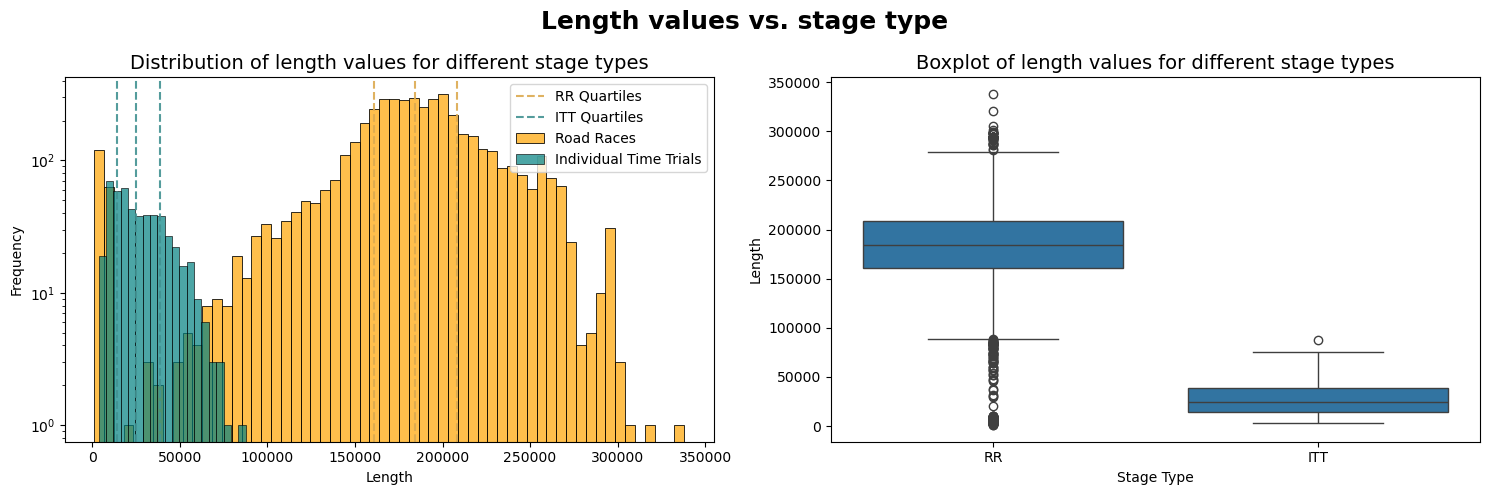

In [32]:
races_df_ = races_df.drop_duplicates(subset=['_url'], keep='first')
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Length values vs. stage type', fontsize=18, fontweight='bold')


sns.histplot(races_df_.loc[races_df_['stage_type'] == 'RR', 'length'], bins=60, kde=False, color='orange', alpha=0.7, label='Road Races', ax=ax[0])
rr_quartiles = races_df_.loc[races_df_['stage_type'] == 'RR', 'length'].quantile([0.25, 0.5, 0.75])

sns.histplot(races_df_.loc[races_df_['stage_type'] == 'ITT', 'length'], bins=20, kde=False, color='teal', alpha=0.7, label='Individual Time Trials', ax=ax[0])
itt_quartiles = races_df_.loc[races_df_['stage_type'] == 'ITT', 'length'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for i, q in enumerate(rr_quartiles):
    label = 'RR Quartiles' if i == 0 else None
    ax[0].axvline(q, linestyle='--', color=(220/255,170/255,80/255), alpha=0.9, label=label)

# Add vertical lines for Individual Time Trials quartiles
for i, q in enumerate(itt_quartiles):
    label = 'ITT Quartiles' if i == 0 else None
    ax[0].axvline(q, linestyle='--', color=(65/255,145/255,145/255), alpha=0.9, label=label)
    
ax[0].set_title('Distribution of length values for different stage types', fontsize=14)
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('log')
ax[0].legend()

sns.boxplot(data=races_df_, x='stage_type', y='length', ax=ax[1])
ax[1].set_title('Boxplot of length values for different stage types', fontsize=14)
ax[1].set_xlabel('Stage Type')
ax[1].set_ylabel('Length')



plt.tight_layout()
plt.show()

As we can see, the two distributions are very well separated visually, but there is some overlap, because there are short road races.

In [33]:
# Not the best... To review... To do better... Maybe with the name_stage feature?
races_df.loc[(races_df['length'] < 100000) & (races_df['stage_type'] == 'RR'), 'name'].unique()

array(['Volta Ciclista a Catalunya', 'La Vuelta ciclista a España',
       'Tour de Romandie', 'Tour de Suisse', 'Paris - Nice',
       "Giro d'Italia", 'Tour de France', 'Tirreno-Adriatico',
       'Criterium du Dauphiné', 'Itzulia Basque Country'], dtype=object)

In [34]:
races_df_.groupby('stage_type')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
stage_type,,,,,,,,
ITT,512.0,27820.976562,15916.229561,3600.0,14150.0,24850.0,38725.0,87500.0
RR,4769.0,180486.781296,53072.679256,1000.0,160700.0,184000.0,208500.0,338000.0


As we can see, `RR` is the majority class. 

The average length of a `ITT` is 29,7 Km, very close to the median, that is 28 Km. <br>
The average length of a `RR` is 180 Km, very close to the median, that is 183 Km.

We can notice that all the mass of the `ITT`'s length distribution is before the first quartile of the `RR`'s length distribution. 

The analysis just performed seems to suggest that higher `length` values correspond to Road Races, and lower `length` values correspond to ITTs.

A way to further assess this idea is the [Point-biserial correlation](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient), a coefficient that can be used to evaluate the correlation between the `length` (which is continuous) and the values of $\delta_{\mathtt{stage\_type} == \mathtt{RR}}$ ($\delta$ stands for an indicator variable, so is binary).

In [35]:
correlation, _ = stats.pointbiserialr(races_df_['stage_type'] == 'RR', races_df_['length'])
print(f"Point-biserial correlation between the stage_type and the lengths: {correlation:.3f}")

Point-biserial correlation between the stage_type and the lengths: 0.665


We expected a value even closer to 1. But one has to notice that there are very short Road Races as well. As a introduction to the next subparagraph, let's repeat the analysis, this time excluding the `prologue` stages.

In [36]:
no_prologue_races_df_ = races_df_[~races_df_['_url'].str.contains('prologue')]

correlation, _ = stats.pointbiserialr(no_prologue_races_df_['stage_type'] == 'RR', no_prologue_races_df_['length'])
print(f"Point-biserial correlation between the stage_type and the lengths, excluding the 'prologue' stages: {correlation}")
#print(f"P-value: {p_value}")

Point-biserial correlation between the stage_type and the lengths, excluding the 'prologue' stages: 0.7736323415578312


Now the correlation is much stronger!

All in all, `length` is an excellent predictor of `stage_type`, but not a perfect one (mainly because of the `prologue` stages). It's ok to have the ground truth.

### `startlist_quality` vs `stage_type`

We can see if other bimodal distributions are "caused" by the `stage_type`, let's analize the `startlist_quality` in the same way

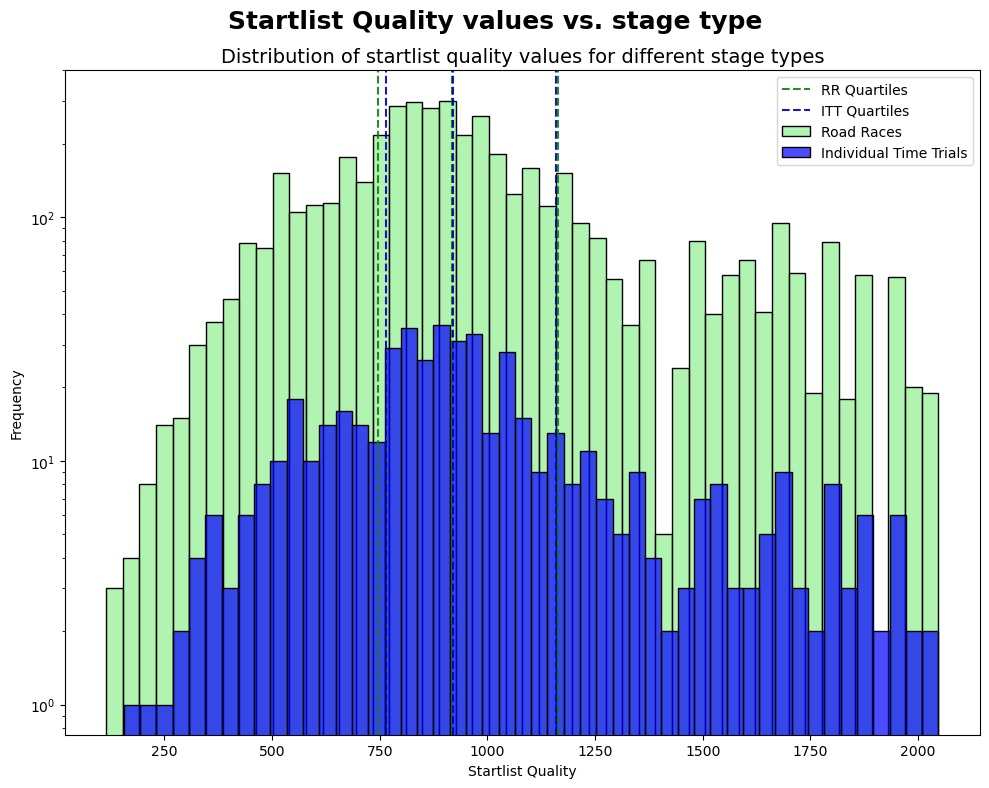

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Startlist Quality values vs. stage type', fontsize=18, fontweight='bold')

sns.histplot(races_df_.loc[races_df_['stage_type'] == 'RR', 'startlist_quality'], bins=50, kde=False, color='lightgreen', alpha=0.7, label='Road Races', ax=ax)
rr_quartiles = races_df_.loc[races_df_['stage_type'] == 'RR', 'startlist_quality'].quantile([0.25, 0.5, 0.75])

sns.histplot(races_df_.loc[races_df_['stage_type'] == 'ITT', 'startlist_quality'], bins=50, kde=False, color='blue', alpha=0.7, label='Individual Time Trials', ax=ax)
itt_quartiles = races_df_.loc[races_df_['stage_type'] == 'ITT', 'startlist_quality'].quantile([0.25, 0.5, 0.75])

# Add vertical lines for Road Races quartiles
for i, q in enumerate(rr_quartiles):
    label = 'RR Quartiles' if i == 0 else None
    ax.axvline(q, linestyle='--', color=(15/255,127/255,15/255), alpha=0.9, label=label)

# Add vertical lines for Individual Time Trials quartiles
for i, q in enumerate(itt_quartiles):
    label = 'ITT Quartiles' if i == 0 else None
    ax.axvline(q, linestyle='--', color=(0/255,0/255,180/255), alpha=0.9, label=label)
    
ax.set_title('Distribution of startlist quality values for different stage types', fontsize=14)
ax.set_xlabel('Startlist Quality')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()

This is the opposite of what I was expecting but is indeed intresting to see that the distributions have almost the same shape, this could suggest that the people racing are the same.

***Andrea***: *I think that it's reasonable that the two frequencies follow the same patterns, the `RR` one being a "dilated" version of the `ITT` one, because basically in all the staged races there's one stage that is an ITT and more or less will have the same participants of all the other stages (therefore the same `startlist_quality`). Most of the competitions are staged (we should assess that...), the non-staged ones "add a little bit of noise to this process", but could look more into detail if so wishes. But maybe you had a different idea.*

We think that the road races that are short can be *prologue* of stage races. We suppose this after we've seen that the shortest race is a prologue. If this is true we could say that the distribution of non prologue RR is more or less Normal

### A deeper study of `length`

First of all we need to create a column that tells us the stage name near the name, s.t. we don't need to retrieve the information from the `_url` each time

In [38]:
def get_name_stage(row) -> Tuple[str, str]:
    array_of_info = row['_url'].split('/')
    array_of_info[-1] = np.nan if array_of_info[-1] == 'result' else array_of_info[-1]
    return array_of_info[0], array_of_info[-1]

#define column name
races_df['stage'] = races_df.apply(lambda row: get_name_stage(row)[1], axis=1)
# move name column to the second position
cols = list(races_df.columns)
cols.insert(2, cols.pop(cols.index('stage')))
races_df = races_df[cols]

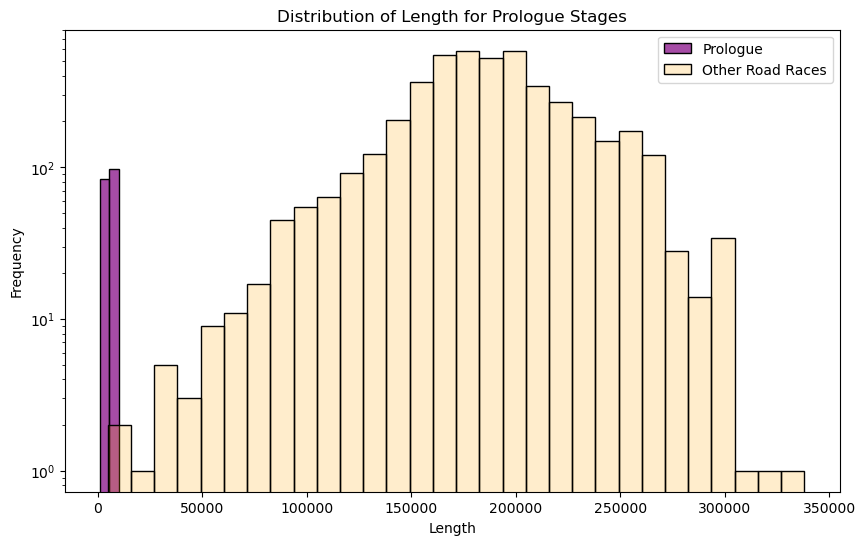

In [39]:
prologue_races = races_df.drop_duplicates(subset=['_url'])
other_rr = prologue_races[(prologue_races['stage_type'] == 'RR') & (prologue_races['stage'] != 'prologue')]
prologue_races = prologue_races[prologue_races['stage'] == 'prologue']

plt.figure(figsize=(10, 6))
sns.histplot(prologue_races['length'], bins=2, kde=False, color='purple', alpha=0.7)
sns.histplot(other_rr['length'], bins=30, kde=False, color='orange', alpha=0.2)
plt.title('Distribution of Length for Prologue Stages')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend(['Prologue', 'Other Road Races'])
plt.show()

We can discuss about the color palette of this plot, and the way it is obtained, but for sure we can say that prologues are the short road races. To see this even better, let's control the distribution of just the prologue length since now it is all compressed to the left. 

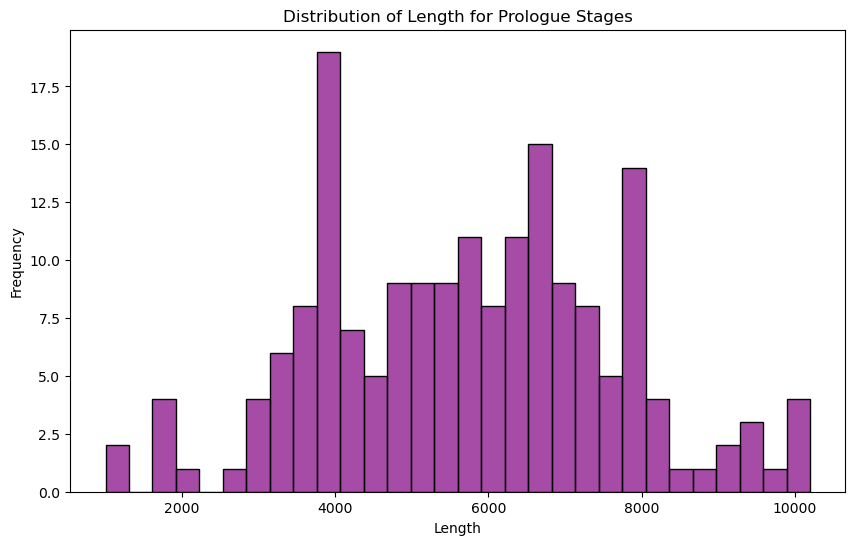

In [40]:
races_df_ = races_df.drop_duplicates(subset=['_url'])
# Filter the races where the stage is a prologue
prologue_races = races_df_[races_df_['stage'] == 'prologue']

# Plot the length of these races
plt.figure(figsize=(10, 6))
sns.histplot(prologue_races['length'], bins=30, kde=False, color='purple', alpha=0.7)
plt.title('Distribution of Length for Prologue Stages')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [41]:
print('There are:', prologue_races[prologue_races['stage_type'] == 'RR'].shape[0], "RR")
print("      and:", prologue_races[prologue_races['stage_type'] == 'ITT'].shape[0],"ITT")

There are: 180 RR
      and: 1 ITT


Nice, we discovered that the shape of the overall shape of the length distribution was given by the summation of 3 different "almost gaussian distribution". We can also see that one prologue only was an ITT race, and there are not many analysis we can do on a single value...

#### Is it normal, though?

We've gone a long way in analyzing the `length` values. The initial distribution $\mathbb{P}(\mathtt{length})$ didn't look nice, but then we noticed that by looking at the `stage_type` the distributions $\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{RR})$ and $\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT})$ are well separated.

$$\begin{align*} 
    \mathbb{P}(\mathtt{length})&=\sum_{s\in\{\mathtt{RR},\mathtt{ITT}\}}\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{s})\\
    &= \mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{RR})+\mathbb{P}(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT})
\end{align*}
$$

But we saw that the distribution of the `RR` stages' length had many small values, and discovered that it was the "fault" of the `prologue` stages. The `prologue` stages are significantly shorter than the non-`prologue` ones, and almost all the `prologue` stages are `RR` stages, we'll just ignore the only `ITT` and `prologue` stage.

By isolating the `prologue` stages, we noticed that the `length` distribution was even nicer. Therefore we claim that the "proper" vay to interpret the distribution of the length values is the following:

$$ \mathbb{P}(\mathtt{length}) = \mathbb{P}\left(\mathtt{length},\mathtt{stage\_type}=\mathtt{ITT}\right)+\mathbb{P}\left(\mathtt{length},\neg\,\mathtt{prologue}\right) +\mathbb{P}(\mathtt{length},\mathtt{prologue})$$

(we didn't mention the $\mathtt{stage\_type}=\mathtt{RR}$ when `prologue` was mentioned, to remove redundancies).



We said that the distribution of the non-prologue stages' length is almost normal. Is it normal, though? 

Well, it's time for statistical hypothesis testing!

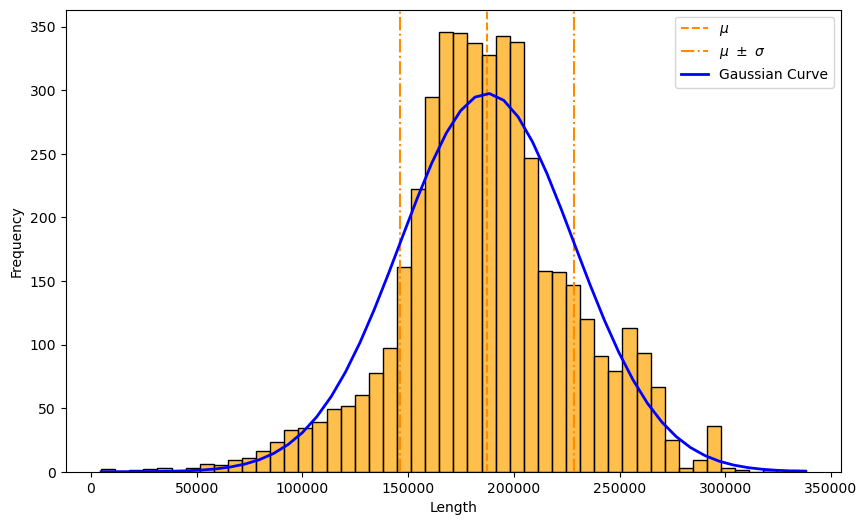

In [42]:
plt.figure(figsize=(10, 6))

non_prologue_length_values = other_rr['length']#.values
mean = non_prologue_length_values.mean()
std = non_prologue_length_values.std()

n_bins = 50

sns.histplot(non_prologue_length_values, bins=n_bins, kde=False, color='orange', alpha=0.7)
plt.axvline(mean, color='darkorange', linestyle='--', label=r'$\mu$')
plt.axvline(mean + std, color='darkorange', linestyle='-.', label=r'$\mu\ \pm\ \sigma$')
plt.axvline(mean - std, color='darkorange', linestyle='-.')

# Generate x values, for the Gaussian curve
x = np.linspace(non_prologue_length_values.min(), non_prologue_length_values.max(), n_bins)#, non_prologue_length_values.shape[0])

# Generate y values for the Gaussian curve
y = stats.norm.pdf(x, mean, std) * len(non_prologue_length_values) * (non_prologue_length_values.max() - non_prologue_length_values.min()) / n_bins  # Adjusting for histogram scaling

# Plot the Gaussian curve
plt.plot(x, y, color='blue', linestyle='-', linewidth=2, label='Gaussian Curve')

plt.xlabel('Length')
plt.ylabel('Frequency')
#plt.yscale('log')
plt.legend()
plt.show()


We now conduct a $\chi^2$ test on `non_prologue_length_values` with expected frequencies given by a normal random variable with law $\mathcal{N}(\mu,\sigma^2)$, where $\mu$ and $\sigma$ are (respectively) the mean and standard deviation of `non_prologue_length_values`.

An important observation is that the binning has a crucial impact on the outcome of the test. 

In [43]:
# Get the observed frequencies, grouping them in n_bins evenly spaced bins
observed_freq, bin_edges = np.histogram(non_prologue_length_values, bins=n_bins)

# Calculate the expected frequencies using the cumulative distribution function of our Gaussian
expected_freq = len(non_prologue_length_values) * np.diff(stats.norm.cdf(bin_edges, mean, std))

# Normalize the expected frequencies to match the sum of the observed frequencies (otherwise stats.chisquare will complain)
expected_freq *= observed_freq.sum() / expected_freq.sum()

chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Interpretation
# We fix alpha, the power of the test, to be 0.05
alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis: The data is approximately normally distributed.")
else:
    print("Reject the null hypothesis: The data is not approximately normally distributed.")

Chi-squared Statistic: 650.4256363204169
P-value: 5.369475186797817e-106
Reject the null hypothesis: The data is not approximately normally distributed.


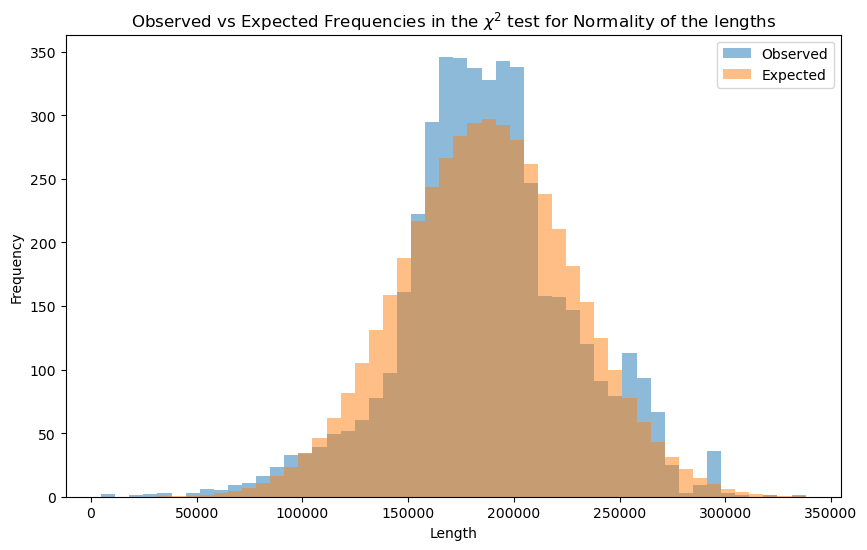

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(bin_edges[:-1], bin_edges, weights=observed_freq, alpha=0.5, label='Observed')
plt.hist(bin_edges[:-1], bin_edges, weights=expected_freq, alpha=0.5, label='Expected')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(r'Observed vs Expected Frequencies in the $\chi^2$ test for Normality of the lengths')
plt.show()

Well, we can't conclude that the values of `length` follow a normal distribution, but it was worth trying.

### `total_points`, `total_points` vs `average_position`

Up to now there is no way of knowing which cyslist is the best, and probably also at the end of the project we will not be able to say who's the best... But at least we can try to give an estimate based on who has accumulated more points (**considering only the races in our dataset**)

In [45]:
## Group by cyclist and sum the points
#points_per_cyclist = races_df.groupby('cyclist')['points'].sum().reset_index()

## Rename the columns for clarity
#points_per_cyclist.columns = ['name', 'total_points']

## Merge the points data with the cyclist_df
#cyclist_df = cyclist_df.merge(points_per_cyclist, left_on='_url', right_on='name', how='left')
#cyclist_df = cyclist_df.drop(columns=['name_y'])
#cyclist_df = cyclist_df.rename(columns={'name_x': 'name'})

## Fill NaN values with 0 (for cyclists who have no points in the races_df)
#cyclist_df['total_points'] = cyclist_df['total_points'].fillna(0)

# The `total_points` column is already in the `cyclist_df` DataFrame, it has been calculated earlier

cyclist_df.head()

,_url,name,birth_year,weight,height,nationality,bmi,race_count,experience_level,total_points,victories_by_points,average_position
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy,NaN,1.0,beginner,0.0,0,110.000000
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France,22.340297,223.0,pro,1354.0,0,63.345291
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands,19.316369,49.0,developing,60.0,0,87.693878
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium,21.158854,164.0,semi-pro,300.0,0,83.707317
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain,18.809206,50.0,competitive,5.0,0,69.260000


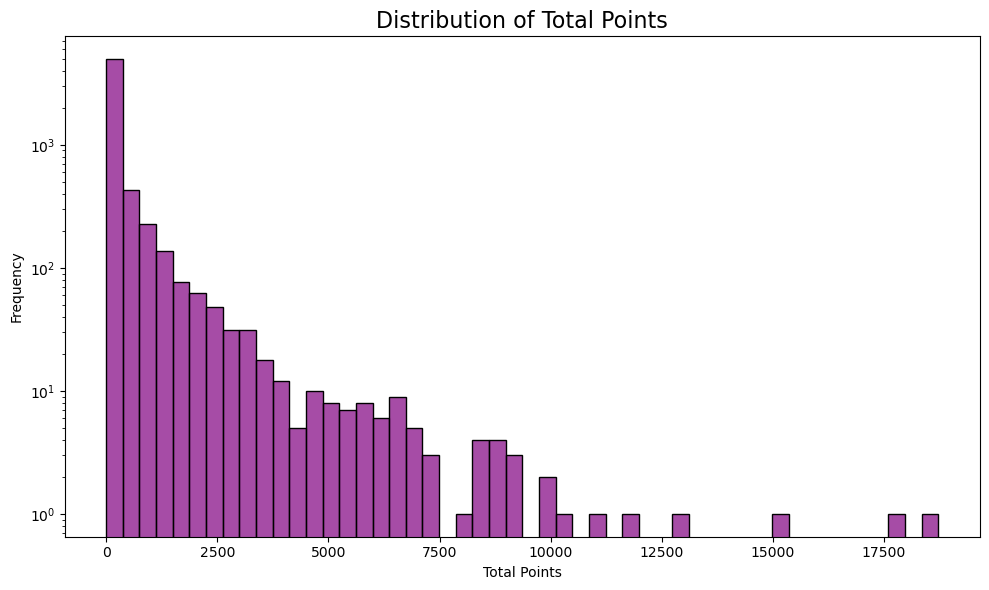

In [65]:
plt.figure(figsize=(10, 6))

sns.histplot(cyclist_df['total_points'], bins=50, kde=False, color='purple', alpha=0.7)
plt.title('Distribution of Total Points', fontsize=16)
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.show()

I must be honest, I didn't expect this shape. Like all things, I expected a bell-shaped curve (everything is normal in Computer Science, isn't it?). 

But it makes sense, right? It makes sense that most of the cyclists have few points, and less and less cyclists have more points. I mean, it makes sense, but still is impressive. It's in log scale!

There are cyclists that have a lot of points. Who are these madmen?!?

In [60]:
cyclist_df[cyclist_df['total_points'] > 10000]

,_url,name,birth_year,weight,height,nationality,bmi,race_count,experience_level,total_points,victories_by_points,average_position
1613,sean-kelly,Sean Kelly,1956.0,77.0,180.0,Ireland,23.765432,635.0,pro,18726.0,29,16.067717
2068,greg-van-avermaet,Greg Van Avermaet,1985.0,74.0,181.0,Belgium,22.587833,593.0,pro,10189.0,6,44.750422
2276,peter-sagan,Peter Sagan,1990.0,78.0,182.0,Slovakia,23.547881,592.0,pro,15220.0,27,54.741554
2512,alejandro-valverde,Alejandro Valverde,1980.0,61.0,177.0,Spain,19.470778,965.0,pro,17728.0,19,24.401036
3989,erik-zabel,Erik Zabel,1970.0,69.0,178.0,Germany,21.777553,725.0,pro,13077.0,11,41.113103
4274,laurent-jalabert,Laurent Jalabert,1968.0,66.0,176.0,France,21.306818,570.0,pro,11770.0,16,26.705263
4551,philippe-gilbert,Philippe Gilbert,1982.0,75.0,178.0,Belgium,23.671254,857.0,pro,10948.0,16,51.226371


They won a lot (by points), but they also participated to a lot of races.

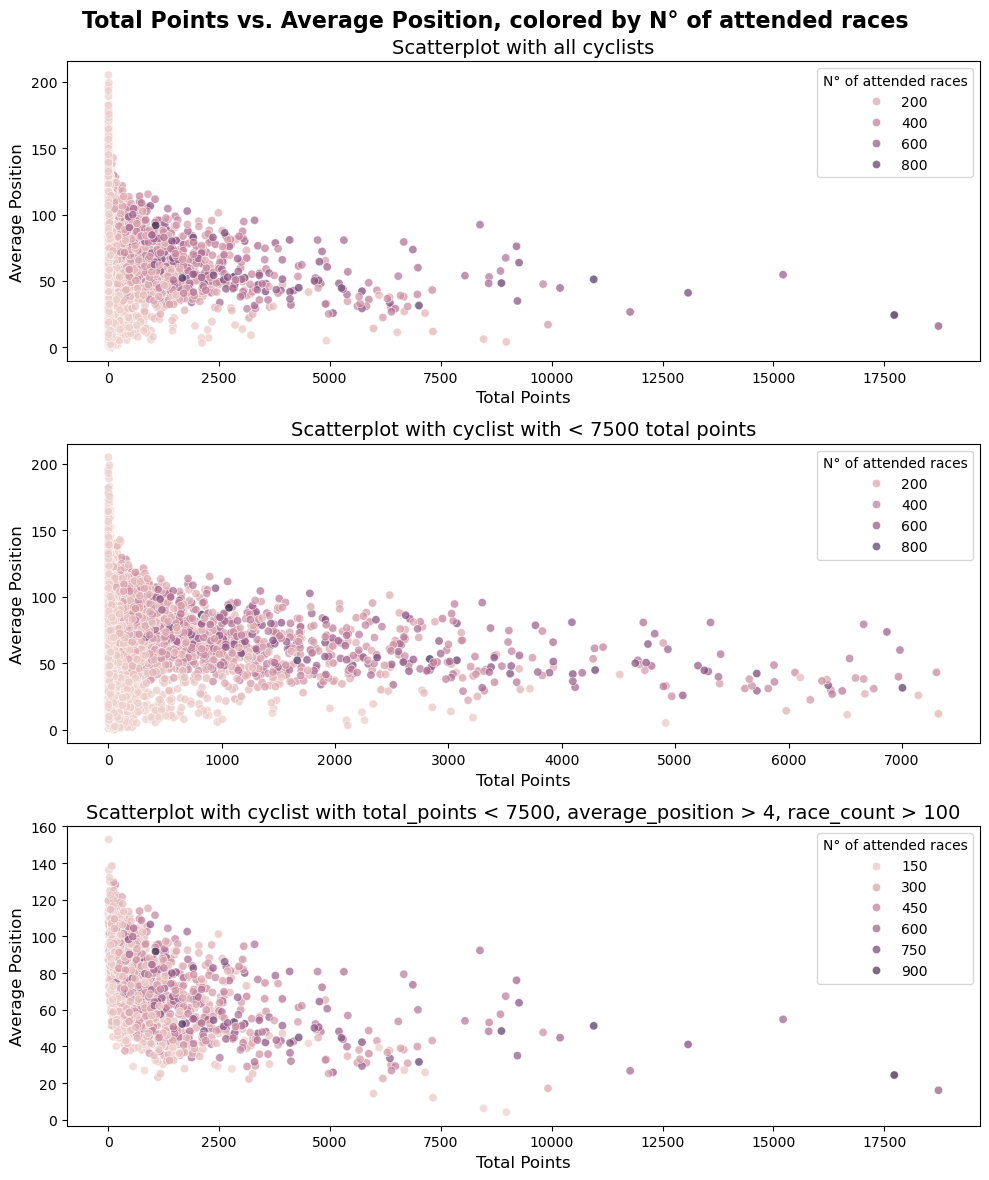

In [93]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Total Points vs. Average Position, colored by N° of attended races', fontsize=16, fontweight='bold')
TOT_PTS_THRESHOLD = 7500

exclude_non_partecipants_df = cyclist_df[cyclist_df['race_count'] > 0]

sns.scatterplot(data=exclude_non_partecipants_df[['total_points','average_position','race_count']], x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[0])
ax[0].set_title('Scatterplot with all cyclists', fontsize=14)
ax[0].set_xlabel('Total Points', fontsize=12)
ax[0].set_ylabel('Average Position', fontsize=12)
ax[0].legend(title='N° of attended races')

sns.scatterplot(data=exclude_non_partecipants_df[exclude_non_partecipants_df['total_points'] < TOT_PTS_THRESHOLD][['total_points','average_position','race_count']],
                 x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[1])
ax[1].set_title(f'Scatterplot with cyclist with < {TOT_PTS_THRESHOLD} total points', fontsize=14)
ax[1].set_xlabel('Total Points', fontsize=12)
ax[1].set_ylabel('Average Position', fontsize=12)
ax[1].legend(title='N° of attended races')

def even_more_filtering(df: pd.DataFrame, avg_pos_thresh: float, race_count_thresh: int) -> pd.DataFrame:
    ret_df = df[df['average_position'] > avg_pos_thresh]
    ret_df = ret_df[ret_df['race_count'] > race_count_thresh]
    return ret_df

avg_pos_thresh, race_count_thresh = 4, 100
sns.scatterplot(data=even_more_filtering(exclude_non_partecipants_df, avg_pos_thresh=avg_pos_thresh, race_count_thresh=race_count_thresh)[['total_points','average_position','race_count']],
                 x='total_points', y='average_position', hue='race_count', alpha=0.7, ax=ax[2])
ax[2].set_title(f'Scatterplot with cyclist with total_points < {TOT_PTS_THRESHOLD}, average_position > {avg_pos_thresh}, race_count > {race_count_thresh}', fontsize=14)
ax[2].set_xlabel('Total Points', fontsize=12)
ax[2].set_ylabel('Average Position', fontsize=12)
ax[2].legend(title='N° of attended races')

plt.tight_layout()
plt.show()


From the scatterplots above we can see that:
- As the `total_points` value increase, the number of attended races increases. This is to be expected
- There's a big lump of points corresponding to low `average_position` value, but also few participations (therefore few Total Points), in the bottom left corner. If we exclude those that participated to few races, these values go away. This seems to indicate that there are many cyclists that get good results in few stages, and then end their career. As a proof of this, by increasing the `race_count` threshold, this lump of points vanishes
- There are "occasional riders": cyclists that have a very high `average_position` value but also very few participations. By filtering per participation, the points corresponding to high `average_position` go away
- To low `total_points` values, there corresponds many values for `average_position`. As the Total Points increase, the Average Position slowly decreases
- There are some cyclists that participated to few races, but not *very few*, and have a decent amount of `total_points` and a very low value for `average_position`. As said, the average has the problem of being less significative if it's taken over few elements
- By comparing the second subplot with the first subplot, with a low threshold for the Average Position, we can see that many points that populate the high-valued part of the Total Points axis disappear. This means that it's actually the `race_count` threshold that removes them. In turn, this means that the highest achievers in terms of total points participated to few races! Of course they aren't the top achievers because the subplots 2 and 3 have a threshold on `total_points`

### `race_country` and the cyclists' nationality

Is it true that the competitions in a given nation tend to be won by cyclist of that same nation?

In [46]:
nationality_df = races_df.copy()[['_url','race_country']]
nationality_df.drop_duplicates(subset=['_url'], inplace=True)
nationality_df.head()

,_url,race_country
0,tour-de-france/1978/stage-6,France
106,vuelta-a-espana/2016/stage-14,Spain
271,tour-de-france/2019/stage-21,France
426,volta-a-catalunya/1999/prologue,Spain
545,tour-de-france/2022/stage-9,France


In [47]:
nationality_df = races_df.copy()[['_url','race_country']]

# We just need one row per url, actually
nationality_df.drop_duplicates(subset=['_url'], inplace=True)
# We don't need all the url, just the base one, actually
# We re-use the `get_base_url` function defined above, for the `victories_by_points` feature
nationality_df['race_url'] = nationality_df['_url'].apply(get_base_url)
nationality_df.drop(columns=['_url'], inplace=True)

# We drop the duplicates of `race_url` (the multiple stages now have the same `race_url`)
nationality_df.drop_duplicates(subset=['race_url'], inplace=True)

# We create a new column to store who's the winner of that edition
# (we use the top_scorers Series defined above, for the `victories_by_points` feature)
nationality_df['points_winner'] = nationality_df['race_url'].map(top_scorers)
# And we get the nationality of the winner, from the cyclist_df
nationality_df['points_winner_nationality'] = nationality_df['points_winner'].map(cyclist_df.set_index('_url')['nationality'])
nationality_df.head()

,race_country,race_url,points_winner,points_winner_nationality
0,France,tour-de-france/1978,freddy-maertens,Belgium
106,Spain,vuelta-a-espana/2016,christopher-froome,Great Britain
271,France,tour-de-france/2019,caleb-ewan,Australia
426,Spain,volta-a-catalunya/1999,george-hincapie,United States
545,France,tour-de-france/2022,tadej-pogacar,Slovenia


In [48]:
nationality_df[nationality_df['race_url'] == 'uae-tour/2019']

,race_country,race_url,points_winner,points_winner_nationality
11815,UAE,uae-tour/2019,fernando-gaviria,Colombia


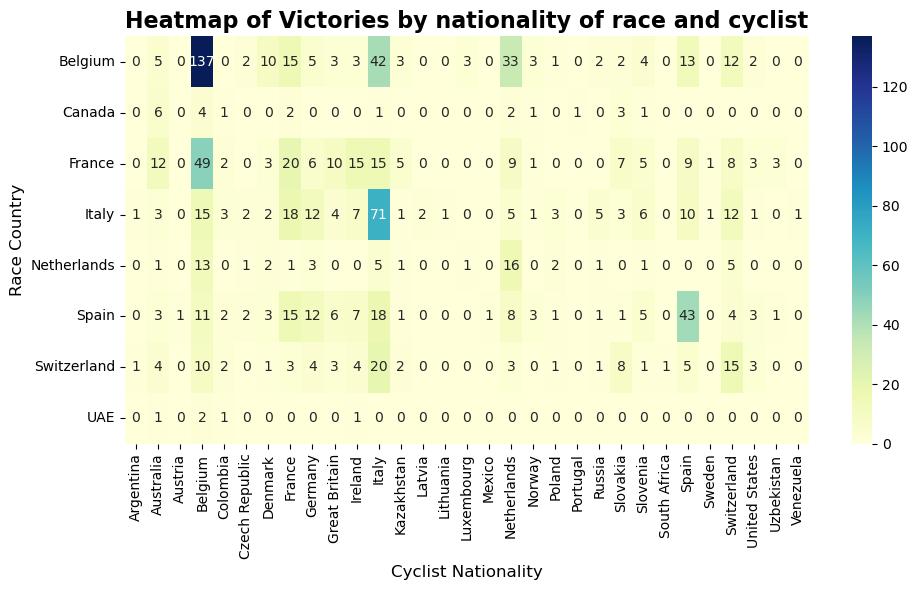

In [49]:
# Count the number of victories by nationality
victory_counts = nationality_df.groupby(['race_country', 'points_winner_nationality']).size().unstack(fill_value=0)

# Plot the heatmap with counts
plt.figure(figsize=(10, 6))
sns.heatmap(victory_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Victories by nationality of race and cyclist', fontsize=16, fontweight='bold')
plt.xlabel('Cyclist Nationality', fontsize=12)
plt.ylabel('Race Country', fontsize=12)

plt.tight_layout()
save_plot(plt, IMAGES_DIR, 'points_winner_nationality_vs_race_country_heatmap.png')
plt.show()

The heatmap above actually tells a lot. General considerations:
- Notice that the Race Country includes many competitions. So, for example we can see that french competitions have been historically won by belgians, but we can't conclude that - for example - the Tour de France has been mostly won by belgians
- The heatmap can be read along the rows, to see which country has hosted the most competitions
- The heatmap can be read along the columns, to see which country has won the most competitions (yes Yuri we know that cyclist ride by themselves, and don't represent a country, but it's just to speak)
- Notice that the heatmap doesn't account for exceptional cyclists. Maybe a country has produced a lot of good cyclists; and another one has produced few cyclist, but each of them won a lot. Well, these two countries may look the same in the heatmap above 

More particular considerations:
- It is confiremd that the main cyclism countries are Belgium, France, Italy, Spain. These countries have hosted most of the competitions, but also gave birth to most of the winners
- There is a strong evidence that most spanish, italian and belgian competitions are won by cyclists from that same country (true victories, not points victories considered in this analysis)
- French competitions are mostly won by belgians, but official statistics say that the Tour de France has mostly been won by frenchmen
- A sizeable quantity of swiss competitions has been won by swiss, but not the majority. The same can be said about the Netherlands. 

# Dataset cleaning

Here we should copy the cleaning notebook because we have here many added feature that are not in the other notebook but that we need in the final cleaned dataset

The delta has already been discussed in an appropriate notebook so here we'll just report the cleaning process

In [50]:
initial_len = races_df.shape[0]
races_df = delta_based_dataset_cleaning(races_df)
final_len = races_df.shape[0]
print(f"removed lines {-final_len-(-initial_len)}")

removed lines 81591


**Bad Columns**

just a reminder of why these are not useful: `is_cobbled` is always false; `is_gravel` is always false; `cyclist_team` can change from year to year and there were some considerations about the fact that the name is just the name of the sponsor (so the team can be the same but with different name); `average_temperature` is almost always null; `Unnamed: 0` is a column created for error somewhere

In [52]:
columns_to_drop = [
    'is_cobbled',
    'is_gravel',
    'cyclist_team',
    'average_temperature',
    #'Unnamed: 0',
]
races_df = races_df.drop(columns=columns_to_drop)
races_df.head()

,_url,name,stage,stage_type,points,uci_points,length,climb_total,profile,startlist_quality,...,is_staged,race_country,norm_points,age_performance_index,quality_adjusted_points,normalized_length,normalized_quality,normalized_steepness,profile_adjustment,stamina_index
0,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,100.0,NaN,162000.0,1101.0,1.0,1241,...,True,France,2.597540,57.145880,3223.547139,0.47929,0.606253,0.065817,0.0,0.28784
1,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,70.0,NaN,162000.0,1101.0,1.0,1241,...,True,France,1.532004,41.364108,1901.216954,0.47929,0.606253,0.065817,0.0,0.28784
2,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,50.0,NaN,162000.0,1101.0,1.0,1241,...,True,France,0.821647,19.719520,1019.663498,0.47929,0.606253,0.065817,0.0,0.28784
3,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,40.0,NaN,162000.0,1101.0,1.0,1241,...,True,France,0.466468,13.994040,578.886770,0.47929,0.606253,0.065817,0.0,0.28784
4,tour-de-france/1978/stage-6,Tour de France,stage-6,RR,32.0,NaN,162000.0,1101.0,1.0,1241,...,True,France,0.182325,4.922776,226.265387,0.47929,0.606253,0.065817,0.0,0.28784


**Saving the dataset**

In [53]:
races_df.to_csv(os.path.join('dataset', 'races_cleaned.csv'), index=False)
cyclist_df.to_csv(os.path.join('dataset', 'cyclists_cleaned.csv'), index=False)

## Rewatch

Let's analyze how some plot changed after all this work

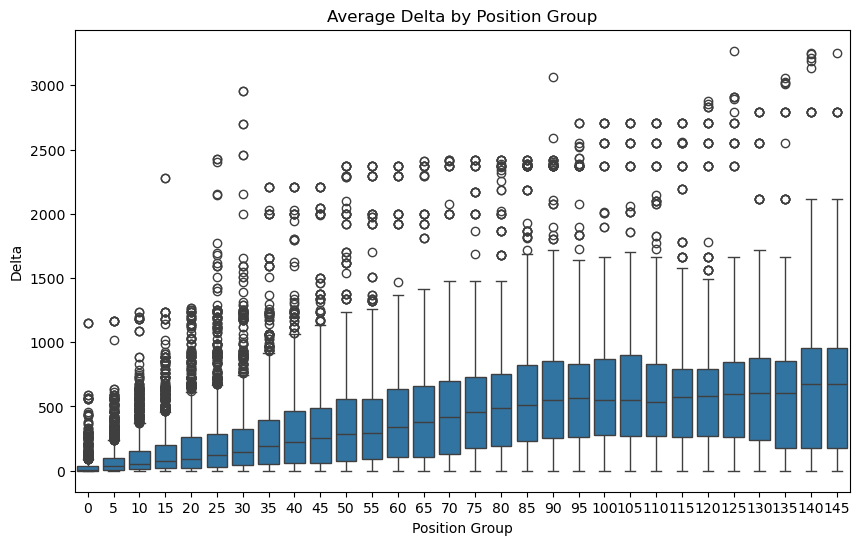

In [54]:
length_range = (250000, 2500000)  # Example length range in meters
# we still consider a subrange of the races because the delta is much
# influenced by this and so is expected a hig variance if we consider all the races
filtered_df = races_df[(races_df['length'] >= length_range[0]) & (races_df['length'] <= length_range[1])]
filtered_df = filtered_df[(filtered_df['stage_type'] == 'RR') & (filtered_df['stage'] != 'prologue')]
filtered_df = filtered_df[filtered_df['position'] < 150]
# Create a new column 'position_group' that groups positions in intervals of 5
filtered_df = filtered_df.assign(position_group=(filtered_df['position'] // 5) * 5)

# Plot the box plot for the average delta by position group
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='position_group', y='delta')
plt.title('Average Delta by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Delta')
plt.show()

This is pretty much the same :(
But some arbitrary cleaning was already done in the previous version, at least we can say tath this one is more 'theoretically grounded'

Anyway, we can see that the delta increse almost logarithmic, this means (personal interpretation to be discussed) that more or less all the athletes are on the same level 